In [189]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Preprocessing 
import re
import nltk
import missingno as msno
from skmultilearn.model_selection import iterative_train_test_split

pd.set_option('display.max_rows', 100)


In [190]:
df = pd.read_csv('QueryResults2.csv')
display(df[:5])
print("Shape of Df:",  df.shape)

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount
0,"Android Jetpack Navigation, BottomNavigationVi...","<p>Android Jetpack Navigation, BottomNavigatio...",<android><android-architecture-components><bot...,50577356,81,67388,14
1,JetPack Compose Button with drawable,<p>How can we achieve this in jetpack compose<...,<android><android-jetpack-compose><android-com...,72336943,10,17903,6
2,How to handle back button when at the starting...,<p>I've started working with the new navigatio...,<android-architecture-components><android-arch...,50937116,17,23616,8
3,TopAppBar flashing when navigating with Compos...,<p>I have 2 screens which both have their own ...,<android><android-jetpack><android-jetpack-com...,68633717,19,4757,9
4,How to create recycler view in Compose Jetpack?,<p>Is there any special way to create recycler...,<android><android-recyclerview><android-jetpac...,58691725,17,12553,7


Shape of Df: (50000, 7)


<Axes: >

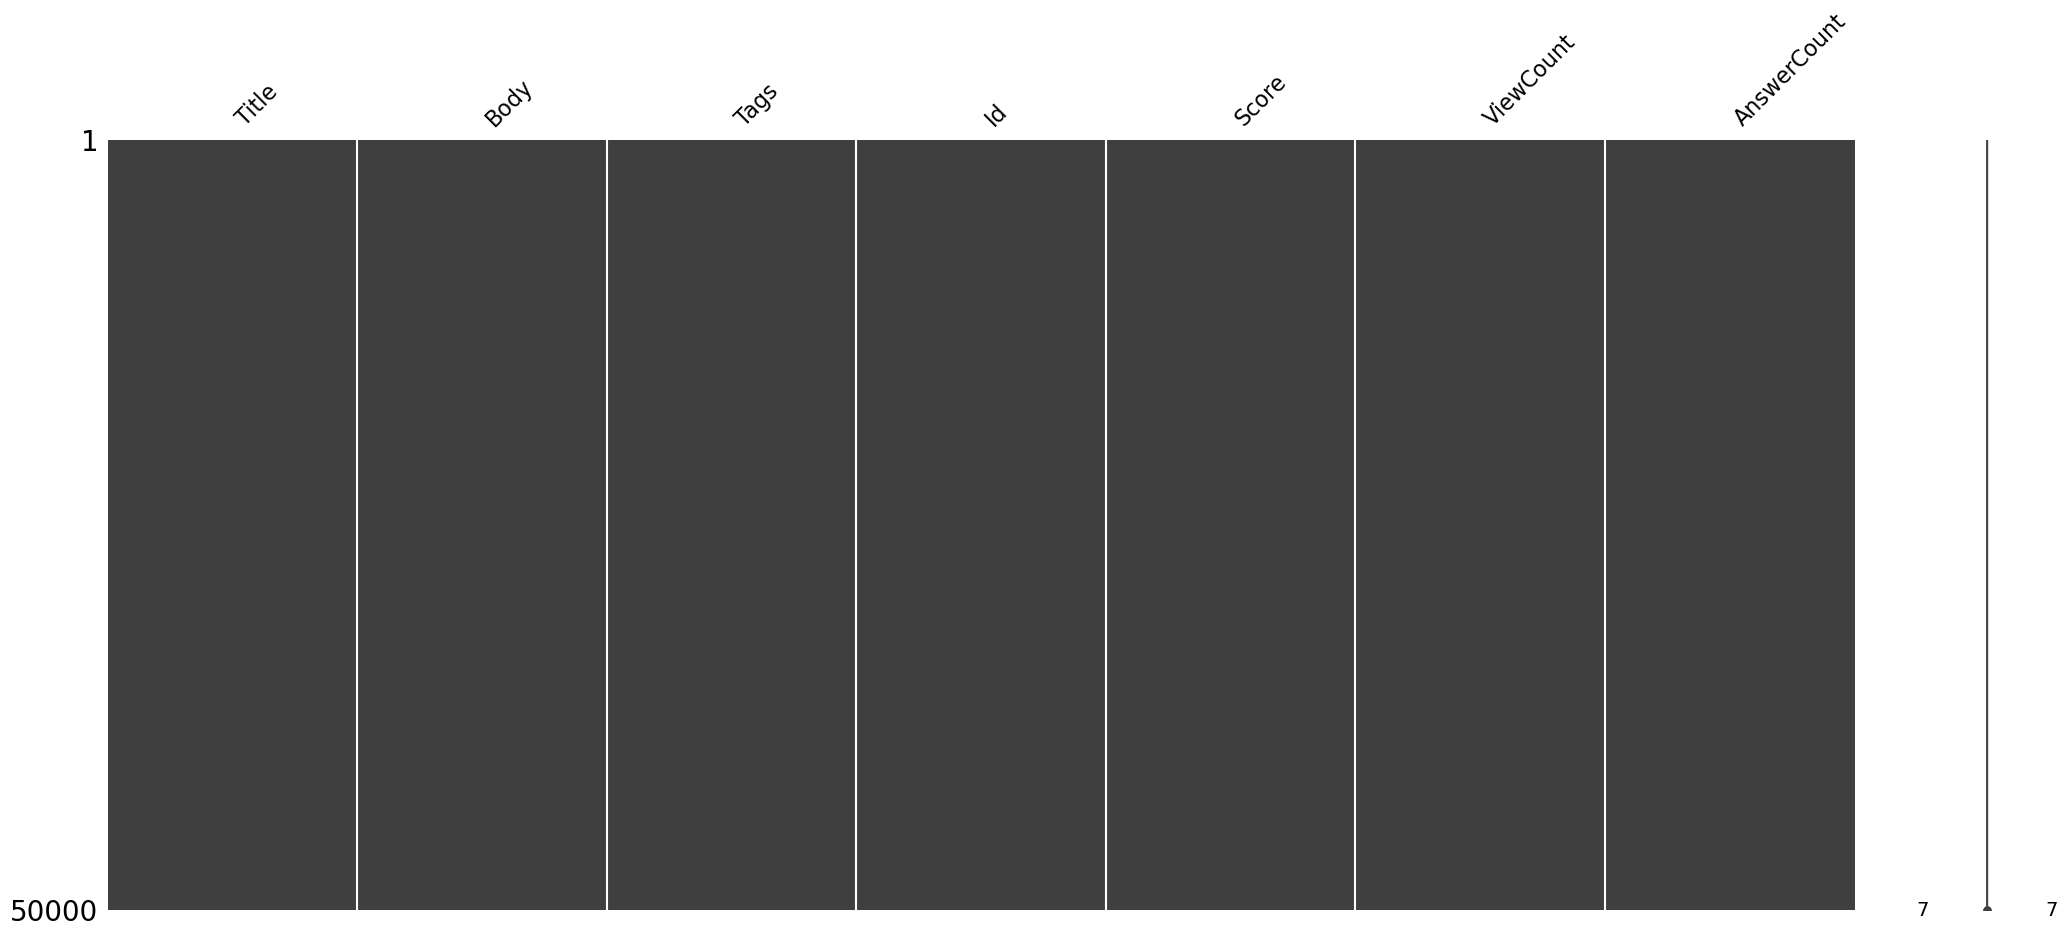

In [191]:
msno.matrix(df)

## Preprocessing Steps:
We will use Pipelines fort the preprocessing steps.  
The first steps of preprocessing will involve cleaning the 'Body' column by removing HTML tags and special characters. After that, we will tokenize the cells.

Here are the steps in detail:
1. Clean the 'Body' column by removing HTML tags and special characters.
2. Tokenize the cells.

Please note that these steps are crucial for preparing the data for further analysis or modeling.

### Body Preprocessing

In [192]:
body = []
body= df.iloc[:].Body
print(body)

0        <p>Android Jetpack Navigation, BottomNavigatio...
1        <p>How can we achieve this in jetpack compose<...
2        <p>I've started working with the new navigatio...
3        <p>I have 2 screens which both have their own ...
4        <p>Is there any special way to create recycler...
                               ...                        
49995    <p>I am trying to POST to <a href="http://loca...
49996    <p>I want my form submit button to be disabled...
49997    <p>Consider a Console application that starts ...
49998    <p>I have a code for adding the texts to exist...
49999    <p>Our maven build throws at the end of the bu...
Name: Body, Length: 50000, dtype: object


In [193]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


class TagsCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.clean_tags(text) for text in X]

    def clean_tags(self, text):
        tags_to_transform = BeautifulSoup(text, "html.parser")
        return [tag.name for tag in tags_to_transform.find_all()]
    
    '''
    def transform(self, X, y=None):
        return [BeautifulSoup(text, "html.parser").get_text() for text in X]'''
    
class HtmlCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.clean_text(text) for text in X]

    def clean_text(self, text):
    # Delete HTML tags
        clean_text = re.sub(r'<.*?>', '', text)
    # Delete special characters and punctuation
        clean_text = re.sub(r'[^a-zA-Z\s]', '', clean_text)
        return clean_text
    
    
    '''def transform(self, X, y=None):
        return [BeautifulSoup(text, "html.parser").get_text() for text in X]'''


class TextTokenizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [nltk.word_tokenize(text) for text in X]

class TextLower(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [[word.lower() for word in text] for text in X]
    
class TextStopWordRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        stop_words = set(nltk.corpus.stopwords.words('english'))
        additional_stopwords = {"im", "ive",'new','like','get','want','would','need','use','using','used','one','two','three','four','five','six','seven','eight','nine','ten',
                                'public','like'
                                'microsoftextensionsdependencyinjectionactivatorutilitiesgetserviceorcreateinstanceiserviceprovider',
                                'uscentraldockerpkgdevprojectidreponamev','use','gt','orgopenqaseleniuminteractionsactionsbuiltactionperformactionsjava',
                                'pageobjectsactivitypageobjectclickaudioinlinestopinactivitypageobjectjava','stepdefinitionactivitytheaudioplayeroftheelementisstoppedinactivityjava'}
        stop_words.update(additional_stopwords)
        return [[word for word in text if word not in stop_words] for text in X]
    
class TextLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [[self.lemmatize(word) for word in text] for text in X]

    def lemmatize(self, word):
        pos_tag = self.get_wordnet_pos(word)
        if pos_tag:
            return self.lemmatizer.lemmatize(word, pos=pos_tag)
        else:
            return word

    def get_wordnet_pos(self, word):
        """Map POS tag to first character used by WordNetLemmatizer"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)
    
pipeline = Pipeline([
    ('html_cleaner', HtmlCleaner()),
    ('tokenizer', TextTokenizer()),
    ('stop_words', TextStopWordRemover()),
    ('text_lower', TextLower()),
    ('tags_cleaner', TagsCleaner()),
    ('lemmatizer',TextLemmatizer())
])

[nltk_data] Downloading package stopwords to /Users/bahia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bahia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bahia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/bahia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [194]:
#preprocessed_body = pipeline.transform(doc[:100])
preprocessed_body = pipeline.named_steps['html_cleaner'].transform(body[:1000])
preprocessed_body = pipeline.named_steps['tokenizer'].transform(preprocessed_body)
preprocessed_body = pipeline.named_steps['text_lower'].transform(preprocessed_body)
preprocessed_body = pipeline.named_steps['lemmatizer'].transform(preprocessed_body)
print(preprocessed_body[0])




['android', 'jetpack', 'navigation', 'bottomnavigationview', 'with', 'auto', 'fragment', 'back', 'stack', 'on', 'back', 'button', 'click', 'what', 'i', 'want', 'after', 'choose', 'multiple', 'tab', 'one', 'after', 'another', 'by', 'user', 'and', 'user', 'click', 'on', 'back', 'button', 'app', 'must', 'redirect', 'to', 'the', 'last', 'page', 'heshe', 'open', 'i', 'achieve', 'the', 'same', 'use', 'android', 'viewpager', 'by', 'save', 'the', 'currently', 'select', 'item', 'in', 'an', 'arraylist', 'be', 'there', 'any', 'auto', 'back', 'stack', 'after', 'android', 'jetpack', 'navigation', 'release', 'i', 'want', 'to', 'achieve', 'it', 'use', 'navigation', 'graph', 'activitymainxml', 'ltxml', 'version', 'encodingutfgt', 'ltandroidsupportconstraintconstraintlayout', 'xmlnsandroidhttpschemasandroidcomapkresandroid', 'xmlnsapphttpschemasandroidcomapkresauto', 'xmlnstoolshttpschemasandroidcomtools', 'androidididcontainer', 'androidlayoutwidthmatchparent', 'androidlayoutheightmatchparent', 'tools

In [195]:
# frequence des tokens
from collections import defaultdict
def calculate_token_frequency(body):
    token_frequency = defaultdict(int)
    for text in body:
        for token in text:
            token_frequency[token] += 1
    sorted_token_frequency = dict(sorted(token_frequency.items(), key=lambda x: x[1], reverse=True))
    return sorted_token_frequency

token_frequency = calculate_token_frequency(preprocessed_body)
print(list(token_frequency.items())[:10])


[('the', 6661), ('be', 4904), ('to', 4150), ('i', 4121), ('a', 3364), ('and', 2327), ('in', 2186), ('at', 1923), ('it', 1710), ('of', 1706)]


Les mots que l'on retrouve le plus sont des stop word il va donc faloir les supprimer
The most frequently occurring words are stop words, so they need to be removed.


In [196]:
preprocessed_body = pipeline.named_steps['stop_words'].transform(preprocessed_body)
print(preprocessed_body[:10])

[['android', 'jetpack', 'navigation', 'bottomnavigationview', 'auto', 'fragment', 'back', 'stack', 'back', 'button', 'click', 'choose', 'multiple', 'tab', 'another', 'user', 'user', 'click', 'back', 'button', 'app', 'must', 'redirect', 'last', 'page', 'heshe', 'open', 'achieve', 'android', 'viewpager', 'save', 'currently', 'select', 'item', 'arraylist', 'auto', 'back', 'stack', 'android', 'jetpack', 'navigation', 'release', 'achieve', 'navigation', 'graph', 'activitymainxml', 'ltxml', 'version', 'encodingutfgt', 'ltandroidsupportconstraintconstraintlayout', 'xmlnsandroidhttpschemasandroidcomapkresandroid', 'xmlnsapphttpschemasandroidcomapkresauto', 'xmlnstoolshttpschemasandroidcomtools', 'androidididcontainer', 'androidlayoutwidthmatchparent', 'androidlayoutheightmatchparent', 'toolscontextmainmainactivitygt', 'ltfragment', 'androidididmynavhostfragment', 'androidnameandroidxnavigationfragmentnavhostfragment', 'androidlayoutwidthmatchparent', 'androidlayoutheightdp', 'appdefaultnavhost

In [197]:

token_body_frequency = calculate_token_frequency(preprocessed_body)
print(token_body_frequency)
import matplotlib.pyplot as plt

# Get the top 50 words and their frequencies
top_50_words = list(token_body_frequency.keys())[:50]
top_50_frequencies = list(token_body_frequency.values())[:50]

{'try': 606, 'work': 578, 'error': 567, 'fragment': 485, 'file': 481, 'code': 477, 'void': 429, 'return': 427, 'override': 419, 'class': 417, 'eandroidruntime': 400, 'view': 383, 'project': 349, 'app': 339, 'version': 329, 'android': 328, 'problem': 316, 'method': 316, 'run': 313, 'set': 312, 'create': 307, 'add': 291, 'androidlayoutwidthmatchparent': 288, 'user': 287, 'follow': 287, 'way': 287, 'implementation': 261, 'string': 259, 'null': 259, 'activity': 258, 'update': 257, 'google': 253, 'also': 252, 'change': 248, 'data': 247, 'call': 237, 'name': 237, 'test': 233, 'see': 231, 'function': 230, 'make': 227, 'private': 227, 'application': 221, 'androidlayoutheightwrapcontent': 210, 'show': 208, 'issue': 200, 'know': 199, 'int': 194, 'time': 194, 'item': 191, 'compile': 186, 'look': 185, 'example': 185, 'value': 182, 'import': 182, 'start': 175, 'image': 175, 'object': 174, 'button': 172, 'true': 172, 'found': 172, 'seem': 170, 'layout': 168, 'id': 166, 'false': 166, 'dont': 166, 'su

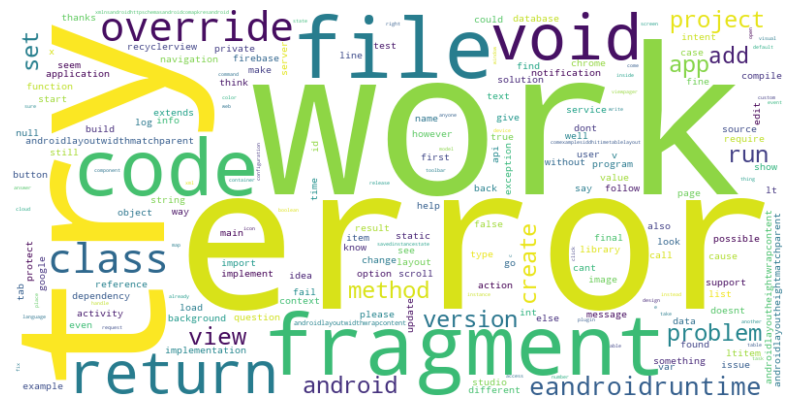

In [198]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Créer l'objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Générer le nuage de mots à partir du dictionnaire de fréquences
wordcloud.generate_from_frequencies(token_body_frequency)

# Afficher le nuage de mots
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Title preprocessing

In [199]:
title = df.iloc[:].Title

preprocessed_title = pipeline.named_steps['html_cleaner'].transform(title[:1000])
preprocessed_title = pipeline.named_steps['tokenizer'].transform(preprocessed_title)
preprocessed_title = pipeline.named_steps['stop_words'].transform(preprocessed_title)
preprocessed_title = pipeline.named_steps['text_lower'].transform(preprocessed_title)
preprocessed_title = pipeline.named_steps['lemmatizer'].transform(preprocessed_title)
print(preprocessed_title)

[['android', 'jetpack', 'navigation', 'bottomnavigationview', 'youtube', 'instagram', 'proper', 'back', 'navigation', 'fragment', 'back', 'stack'], ['jetpack', 'compose', 'button', 'drawable'], ['how', 'handle', 'back', 'button', 'start', 'destination', 'navigation', 'component'], ['topappbar', 'flash', 'navigate', 'compose', 'navigation'], ['how', 'create', 'recycler', 'view', 'compose', 'jetpack'], ['jetpackcompose', 'navigation', 'nest', 'graph', 'cause', 'viewmodelstore', 'set', 'setgraph', 'call', 'exception'], ['how', 'navhostfragment'], ['how', 'align', 'title', 'layout', 'center', 'topappbar'], ['jetpack', 'compose', 'lazycolumn', 'programmatically', 'scroll', 'item'], ['collapse', 'appbarlayout', 'scroll', 'tablayout', 'nestedscrollview'], ['google', 'map', 'android', 'api', 'authorization', 'failure', 'ensure', 'google', 'map', 'android', 'api', 'v', 'enable', 'ensure', 'follow', 'android', 'key', 'exists'], ['visual', 'studio', 'suddenly', 'debug', 'test'], ['why', 'android'

In [200]:
# Title tokens frequency
token_title_frequency = calculate_token_frequency(preprocessed_title)
print(token_title_frequency)


# Get the top 50 words and their frequencies
top_50_words = list(token_title_frequency.keys())[:50]
top_50_frequencies = list(token_title_frequency.values())[:50]

{'how': 168, 'android': 154, 'google': 59, 'error': 59, 'fragment': 50, 'studio': 47, 'i': 41, 'work': 40, 'firebase': 38, 'v': 35, 'set': 34, 'view': 33, 'what': 33, 'navigation': 32, 'activity': 28, 'compose': 27, 'button': 27, 'visual': 27, 'chrome': 27, 'app': 26, 'be': 26, 'create': 25, 'api': 25, 'data': 25, 'cloud': 24, 'change': 24, 'fail': 24, 'file': 24, 'jetpack': 23, 'load': 23, 'background': 23, 'recyclerview': 23, 'can': 22, 'function': 21, 'run': 21, 'notification': 21, 'add': 21, 'scroll': 20, 'text': 20, 'support': 20, 'item': 19, 'why': 19, 'color': 19, 'unable': 19, 'image': 19, 'show': 19, 'name': 19, 'call': 18, 'project': 18, 'access': 18, 'doesnt': 18, 'database': 18, 'component': 17, 'test': 17, 'screen': 17, 'class': 17, 'custom': 17, 'version': 17, 'language': 17, 'library': 17, 'javascript': 17, 'aws': 17, 'server': 17, 'aspnet': 17, 'found': 16, 'window': 16, 'resolve': 16, 'toolbar': 15, 'design': 15, 'action': 15, 'inside': 15, 'icon': 15, 'extension': 15,

### Tags Preprocessing

In [201]:

tags = df.iloc[:].Tags
#print(tags)
preprocessed_tags = pipeline.named_steps['tags_cleaner'].transform(tags[:1000])
print(preprocessed_tags)

[['android', 'android-architecture-components', 'bottomnavigationview', 'android-navigation', 'android-architecture-navigation'], ['android', 'android-jetpack-compose', 'android-compose-textfield', 'android-compose-button', 'android-jetpack-compose-button'], ['android-architecture-components', 'android-architecture-navigation', 'android-navigation', 'android-jetpack-navigation'], ['android', 'android-jetpack', 'android-jetpack-compose', 'android-jetpack-navigation', 'android-jetpack-compose-scaffold'], ['android', 'android-recyclerview', 'android-jetpack-compose', 'android-jetpack-compose-list', 'android-compose-lazyfor'], ['kotlin', 'android-jetpack-compose', 'android-jetpack', 'android-architecture-navigation', 'jetpack-compose-navigation'], ['android', 'android-fragments', 'android-architecture-components', 'fragmentmanager', 'android-architecture-navigation'], ['android', 'android-jetpack-compose', 'android-jetpack', 'android-jetpack-compose-material3', 'android-compose-appbar'], [

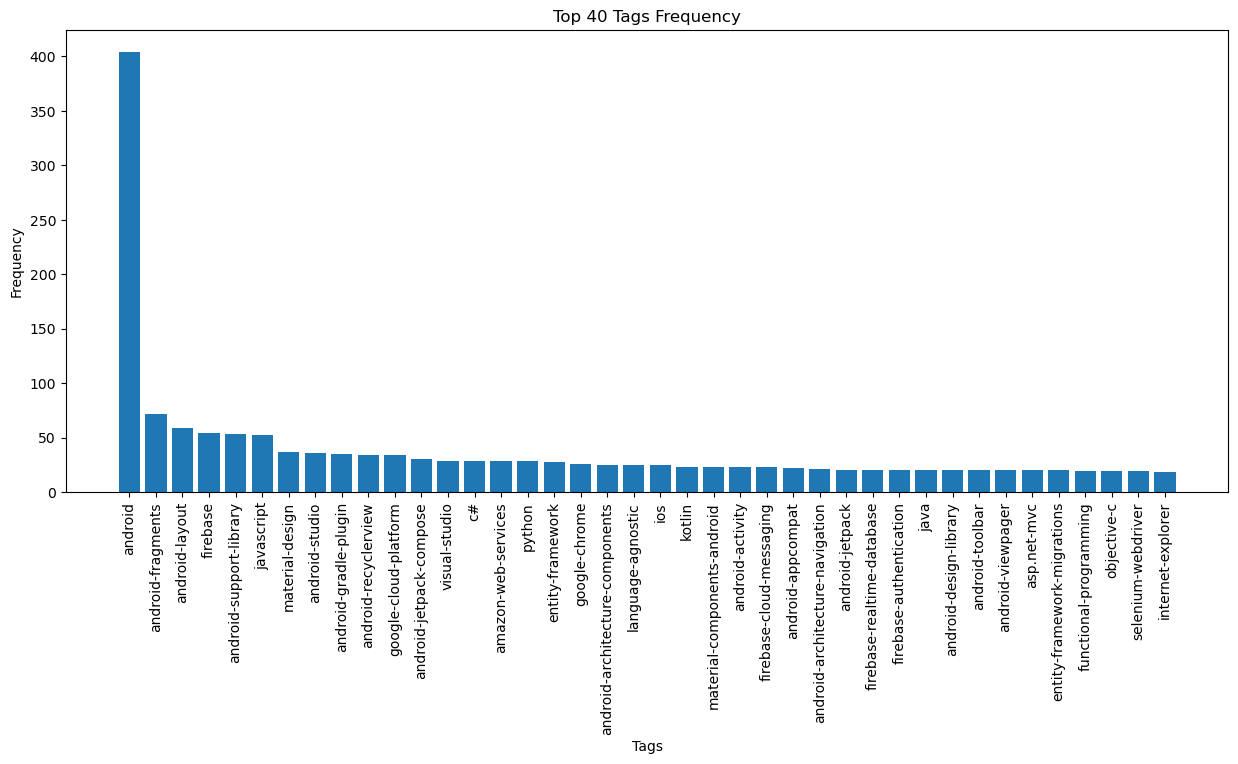

In [202]:
# Tags frequency
tags_frequency = calculate_token_frequency(preprocessed_tags)

# Get the top 10 tags and their frequencies
top_40_tags = list(tags_frequency.keys())[:40]
top_40_frequencies = list(tags_frequency.values())[:40]

# Plot the tags frequency
plt.figure(figsize=(15, 6))
plt.bar(top_40_tags, top_40_frequencies)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 40 Tags Frequency')
plt.xticks(rotation=90)
plt.show()


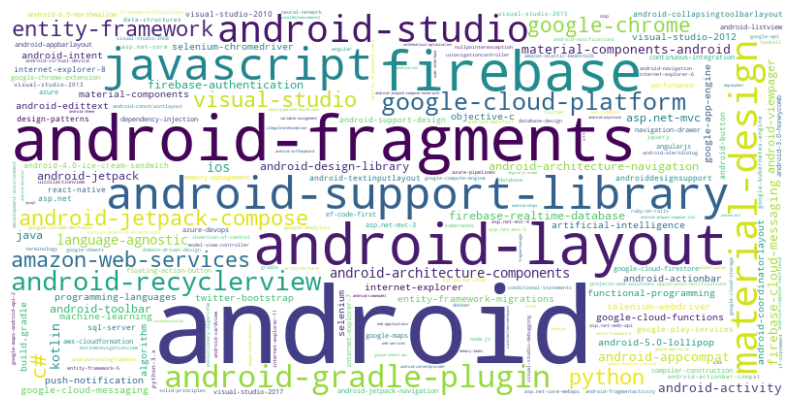

In [203]:
# Créer l'objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Générer le nuage de mots à partir du dictionnaire de fréquences
wordcloud.generate_from_frequencies(tags_frequency)

# Afficher le nuage de mots
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [204]:

lonely_tags = [tag for tag, frequency in tags_frequency.items() if frequency == 1]
print("Lonely tags: ",len(lonely_tags))
print("Total_tags:", len(tags_frequency))

Lonely tags:  1045
Total_tags: 1635


In [205]:
# For each sublist, join its elements into a single string
preprocessed_body = [' '.join(sublist) for sublist in preprocessed_body]
preprocessed_title = [' '.join(sublist) for sublist in preprocessed_title]
preprocessed_tags = [' '.join(sublist) for sublist in preprocessed_tags]

# Convert the lists into DataFrames
df_body = pd.DataFrame(preprocessed_body, columns=['Body'])
df_title = pd.DataFrame(preprocessed_title, columns=['Title'])
df_tags = pd.DataFrame(preprocessed_tags, columns=['Tags'])

# Join the DataFrames
df = pd.concat([df_title, df_body, df_tags], axis=1)
display(df.head())

,Title,Body,Tags
0,android jetpack navigation bottomnavigationvie...,android jetpack navigation bottomnavigationvie...,android android-architecture-components bottom...
1,jetpack compose button drawable,achieve jetpack compose something button eleva...,android android-jetpack-compose android-compos...
2,how handle back button start destination navig...,start work navigation component really dig iss...,android-architecture-components android-archit...
3,topappbar flash navigate compose navigation,screen scaffold topappbar navigate jetpack nav...,android android-jetpack android-jetpack-compos...
4,how create recycler view compose jetpack,special way create recyclerview compose jetpac...,android android-recyclerview android-jetpack-c...


### Body exploration

La longueur moyenne des questions en nombre de mots est de 95.00.
le nombre total de mots : 95005
The number of unique words in df['Body'] is: 18468


/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Body_word_count', ylabel='Count'>

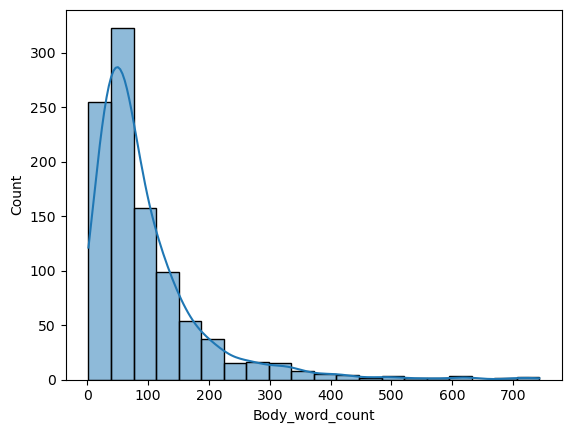

In [206]:

def count_words(text):
    return len(text.split())

# Appliquer la fonction à la colonne 'Body' du jeu de données
df['Body_word_count'] = df['Body'].apply(count_words)

# Calculer la longueur moyenne des questions en nombre de mots
mean_word_count = df['Body_word_count'].mean()

# Nombre de mots et nombre de mots unique dans body
unique_words_count = len(set(' '.join(df['Body']).split()))
total_word_count = df['Body_word_count'].sum() 

print(f"La longueur moyenne des questions en nombre de mots est de {mean_word_count:.2f}.")
print("le nombre total de mots :",total_word_count)
print("The number of unique words in df['Body'] is:", unique_words_count)

sns.histplot(df['Body_word_count'], kde=True, bins=20)



In [207]:
#df['Body_word_count']
import plotly.express as px

px.box(df['Body_word_count'])

Looking for lines with body size < 3   

In [208]:
df_0_word = df[df['Body_word_count'] < 3]
print("Number of questions with less than 3 words:", df_0_word.shape[0])
display("Number of questions with less than 3 words:", df_0_word)

Number of questions with less than 3 words: 1


'Number of questions with less than 3 words:'

,Title,Body,Tags,Body_word_count
442,what typesafe,typesafe mean,language-agnostic programming-languages comput...,2


In [209]:
# Remove the questions with less than 3 words
df = df[df['Body_word_count'] > 2]

try                               606
work                              578
error                             567
fragment                          485
file                              481
code                              477
void                              429
return                            427
override                          419
class                             417
eandroidruntime                   400
view                              383
project                           349
app                               339
version                           329
android                           328
problem                           316
method                            316
run                               313
set                               312
create                            307
add                               291
androidlayoutwidthmatchparent     288
follow                            287
user                              287
way                               287
implementati

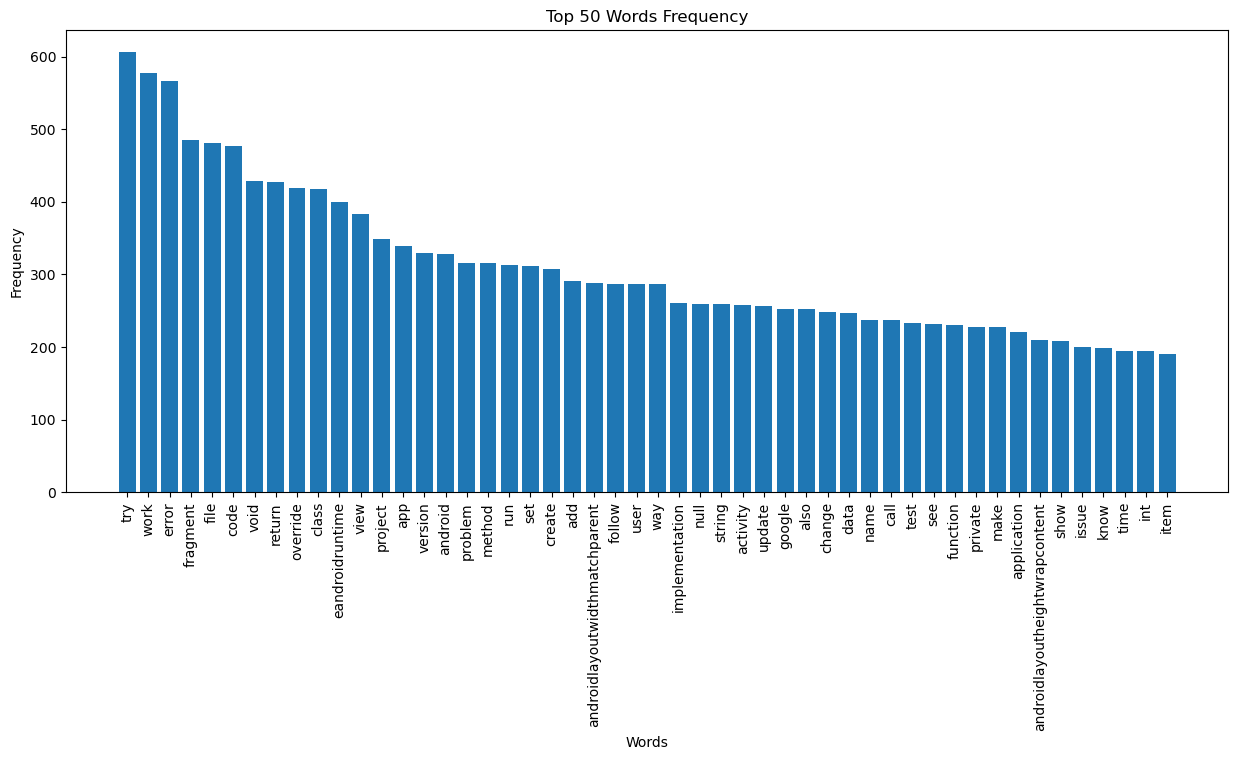

In [210]:
# word frequency
top_50_words = df['Body'].str.split(expand=True).stack().value_counts()[:50]
print(top_50_words)

# Plot the top 50 words frequency
plt.figure(figsize=(15, 6))
plt.bar(top_50_words.index, top_50_words.values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Words Frequency')
plt.xticks(rotation=90)
plt.show()


In [211]:
# word frequency
flop_30_words = df['Body'].str.split(expand=True).stack().value_counts()[30:]
print(flop_30_words)


# Plot the top 50 words frequency
plt.figure(figsize=(15, 6))
plt.bar(flop_30_words.index, flop_30_words.values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('flop 50 Words Frequency')
plt.xticks(rotation=90)
plt.show()

update                                                        257
google                                                        253
also                                                          252
change                                                        248
data                                                          247
                                                             ... 
httpwwwmaterialdoccomsnackbar                                   1
programmatic                                                    1
snackbarsetactiontextcolorgetresourcesgetcolorrcolorindigo      1
snackbartextid                                                  1
allan                                                           1
Name: count, Length: 18437, dtype: int64


In [ ]:
# Pipeline des diffrentes vectorisation
# CountVectorizer (Bag of Words)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline



class CustomCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = CountVectorizer(min_df=0.01)

    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self

    def transform(self, X, y=None):
        return self.vectorizer.transform(X)

pipeline_vec = Pipeline([
    ("count_vectorizer", CustomCountVectorizer())
])

    


### Bag of words

Le "bag of words" est une méthode de représentation de texte sous forme de vecteur numérique. Elle consiste à compter l'occurrence de chaque mot dans le texte, en ignorant leur ordre et leur grammaire. Le résultat est un vecteur où chaque dimension correspond à un mot unique dans le corpus. Cette méthode est largement utilisée  pour représenter des données textuelles.

In [ ]:

X_body = df['Body']
X_body_vectorized =pipeline_vec.named_steps['count_vectorizer'].fit_transform(X_body)

display(X_body_vectorized[0].toarray())
print(X_body_vectorized.shape)

array([[0, 0, 0, ..., 0, 0, 0]])

(999, 1019)


In [ ]:

#Obtenir la liste des mots du vocabulaire

vocab = pipeline_vec.named_steps['count_vectorizer'].vectorizer.get_feature_names_out()
# Extraire la première ligne de X_body
first_row = X_body_vectorized[0]

# Convertir la première ligne en un dictionnaire avec les mots comme clés et les valeurs comme valeurs
first_row_dict = {vocab[i]: first_row[0, i] for i in range(len(vocab))}

# Créer un DataFrame à partir du dictionnaire
df_first_row = pd.DataFrame([first_row_dict])

display(df_first_row)
# Filtrer le DataFrame pour inclure uniquement les colonnes avec des valeurs non nulles
df_first_row_filtered = df_first_row.loc[:, df_first_row.sum() > 0]

# Afficher le DataFrame filtré
display(df_first_row_filtered) 




,able,abstract,access,accord,account,achieve,across,action,actionbar,active,...,write,wrong,xml,xmlnsandroidhttpschemasandroidcomapkresandroid,xmlnsandroidhttpschemasandroidcomapkresandroidgt,xmlnsapphttpschemasandroidcomapkresauto,xmlnstoolshttpschemasandroidcomtools,year,yes,yet
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,1,1,1,1,0,0,0


,achieve,add,also,android,androidlayoutheightdp,androidlayoutheightmatchparent,androidlayoutheightwrapcontent,androidlayoutwidthdp,androidlayoutwidthmatchparent,another,...,stack,tab,user,version,viewpager,want,xmlnsandroidhttpschemasandroidcomapkresandroid,xmlnsandroidhttpschemasandroidcomapkresandroidgt,xmlnsapphttpschemasandroidcomapkresauto,xmlnstoolshttpschemasandroidcomtools
0,2,1,1,3,1,1,1,1,2,1,...,2,1,2,2,1,2,1,1,1,1


Le "bag of words" est une méthode de représentation de texte sous forme de vecteur numérique. Elle consiste à compter l'occurrence de chaque mot dans le texte, en ignorant leur ordre et leur grammaire. Le résultat est un vecteur où chaque dimension correspond à un mot unique dans le corpus. Cette méthode est largement utilisée  pour représenter des données textuelles.


In [ ]:
freqw = X_body_vectorized.sum(axis=0)
frequent_words = pd.Series(freqw.tolist()[0], index=pipeline_vec.named_steps['count_vectorizer'].vectorizer.get_feature_names_out())
print(frequent_words.sort_values(ascending=False)[:5])

public    769
new       677
get       654
try       606
work      578
dtype: int64


In [ ]:
lonely_words = [word for word, frequency in frequent_words.items() if frequency == 1]
print("Lonely words: ",len(lonely_words))
print(lonely_words)
print("Total words :", len(frequent_words))
print("The percentage of lonely words is:", round(len(lonely_words) / len(frequent_words) * 100,2),"%")


Lonely words:  0
[]
Total words : 1019
The percentage of lonely words is: 0.0 %


In [ ]:

tags_to_keep = list(pd.Series(tags_frequency).sort_values(ascending=False).iloc[:50].index)
print(tags_to_keep[:10])

['android', 'android-fragments', 'android-layout', 'firebase', 'android-support-library', 'javascript', 'material-design', 'android-studio', 'android-gradle-plugin', 'android-recyclerview']


In [ ]:
# Supprimer les ligne ou aucun tags ne sont pas dans tags_to_keep
from sklearn.preprocessing import MultiLabelBinarizer
df_tags_filtered = df[df['Tags'].apply(lambda x: any(tag in tags_frequency for tag in x.split()))]
df_tags_filtered.shape
display(df_tags_filtered.head(), df_tags_filtered.shape)

# Supprimer les lignes où aucun tag n'est dans tags_to_keep
mlb = MultiLabelBinarizer(classes=tags_to_keep)
label_tags = pd.DataFrame(mlb.fit_transform(df_tags_filtered['Tags'].apply(lambda x: x.split())), index=df_tags_filtered.index, columns=tags_to_keep)
label_tags.head()

# Concaténer les DataFrames
df_tags_filtered = pd.concat([df_tags_filtered[[ "Body", "Title"]], label_tags], axis=1)
display(df_tags_filtered.head())

,Title,Body,Tags,Body_word_count
0,android jetpack navigation bottomnavigationvie...,android jetpack navigation bottomnavigationvie...,android android-architecture-components bottom...,136
1,jetpack compose button drawable,achieve jetpack compose something like button ...,android android-jetpack-compose android-compos...,62
2,how handle back button start destination navig...,start work new navigation component really dig...,android-architecture-components android-archit...,58
3,topappbar flash navigate compose navigation,screen scaffold topappbar navigate jetpack nav...,android android-jetpack android-jetpack-compos...,199
4,how create recycler view compose jetpack,special way create recyclerview compose jetpac...,android android-recyclerview android-jetpack-c...,7


(999, 4)

/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:900: UserWarning:

unknown class(es) ['abstract-syntax-tree', 'abstraction', 'abstractmethoderror', 'access-control', 'accessibility', 'actionbardrawertoggle', 'actionbarsherlock', 'actionscript', 'active-directory', 'activerecord', 'activity-finish', 'activity-indicator', 'activity-manager', 'activity-transition', 'activitynotfoundexception', 'adapter', 'adb', 'ado.net-entity-data-model', 'aggregation-framework', 'alarmmanager', 'alpha-beta-pruning', 'amazon-athena', 'amazon-cloudfront', 'amazon-cloudwatch', 'amazon-cloudwatch-events', 'amazon-cloudwatchlogs', 'amazon-cognito', 'amazon-ec2', 'amazon-ecs', 'amazon-elastic-beanstalk', 'amazon-elasticsearch', 'amazon-elb', 'amazon-iam', 'amazon-kms', 'amazon-rds', 'amazon-s3', 'amazon-sns', 'amazon-sqs', 'android-10.0', 'android-11', 'android-13', 'android-2.2-froyo', 'android-3.0-honeycomb', 'android-4.0-ice-cream-sandwich', 'android-4.2-jelly-bean', 

,Body,Title,android,android-fragments,android-layout,firebase,android-support-library,javascript,material-design,android-studio,...,algorithm,selenium-chromedriver,android-actionbar,programming-languages,artificial-intelligence,android-5.0-lollipop,android-intent,machine-learning,material-components,android-edittext
0,android jetpack navigation bottomnavigationvie...,android jetpack navigation bottomnavigationvie...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,achieve jetpack compose something like button ...,jetpack compose button drawable,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,start work new navigation component really dig...,how handle back button start destination navig...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,screen scaffold topappbar navigate jetpack nav...,topappbar flash navigate compose navigation,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,special way create recyclerview compose jetpac...,how create recycler view compose jetpack,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
X_fulltrain, y_fulltrain, X_test, y_test = \
    iterative_train_test_split(df_tags_filtered[[ "Body", "Title"]].values,
                               df_tags_filtered[df_tags_filtered.columns[2:]].values,
                               test_size=0.2)

In [ ]:
print(X_fulltrain.shape)
print(y_fulltrain.shape)
print(X_test.shape)
print(y_test.shape)

X_fulltrain = pd.DataFrame(X_fulltrain, columns=["body", "title"])
X_test = pd.DataFrame(X_test, columns=["body", "title"])
y_fulltrain = pd.DataFrame(y_fulltrain, columns=tags_to_keep)
y_test = pd.DataFrame(y_test, columns=tags_to_keep)

(799, 2)
(799, 50)
(200, 2)
(200, 50)


In [ ]:
X_fulltrain.to_csv("Data/X_train.csv")
X_test.to_csv("Data/X_test.csv")
y_fulltrain.to_csv("Data/y_train.csv")
y_test.to_csv("Data/y_test.csv")